# Creating daily ERA-5 Precip (mm/day)

In [1]:
import numpy as np 
import xarray as xr 
import matplotlib.pyplot as plt 
import cartopy
import os
import pandas as pd
import cftime
import datetime as dt
import tqdm
import netCDF4 as nc
import glob

import subprocess
import cftime

In [2]:
calendar_type = 'proleptic_gregorian'
# calendar_type = 'standard'

In [4]:
in_folder = '/localdrive/drive6/era5/data/six_hrly/data_1deg'
deg_type = 'DEG10'

In [9]:
tmpfile = '/localdrive/drive6/era5/data/six_hrly/data_1deg/tp/tp_2014_6hrly.nc'
ds = xr.open_dataset(tmpfile)
print(f'Time Variable Length: {len(ds.time)}\n\n', ds.time)
ds.close()

Time Variable Length: 8760

 <xarray.DataArray 'time' (time: 8760)>
array(['2014-01-01T00:00:00.000000000', '2014-01-01T01:00:00.000000000',
       '2014-01-01T02:00:00.000000000', ..., '2014-12-31T21:00:00.000000000',
       '2014-12-31T22:00:00.000000000', '2014-12-31T23:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
Attributes:
    long_name:  time
<xarray.Dataset>
Dimensions:    (latitude: 181, longitude: 360, time: 8760)
Coordinates:
  * longitude  (longitude) float32 0.0 1.0 2.0 3.0 ... 356.0 357.0 358.0 359.0
  * latitude   (latitude) float32 90.0 89.0 88.0 87.0 ... -88.0 -89.0 -90.0
  * time       (time) datetime64[ns] 2014-01-01 ... 2014-12-31T23:00:00
Data variables:
    tp         (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2020-12-17 09:13:07 GMT by grib_to_netcdf-2.16.0: /opt/ecmw...


# Creating the VAR file that contains all the necessary years

In [6]:
# start year to end year+1
year_range = [2014, 2015]

# var map, variable name in code to the input variable name
in_var_fn_map = {'tp': 'tp'}
in_var_map = {'tp': 'tp'}
in_var_scale = {'tp': 10*100.0}
in_var_offset = {'tp': 0.0}

# var map, variable name in code to the output variable name
out_var_map = {'tp': 'TP'}
out_var_long_name = {'tp': 'Total Precipitation'}
out_var_units = {'tp': 'mm/day'}

In [7]:
days = (dt.datetime(year_range[1], 12, 31) - dt.datetime(year_range[0], 1, 1)).days + 1
print(f'Number of days: {days}')

Number of days: 730


In [10]:
# getting the time dimension length
time_dim = 0
var = 'tp'
in_time = []
in_var = []
for i_year, year in enumerate(range(year_range[0], year_range[1]+1)):
    in_file = os.path.join(in_folder, f"{in_var_fn_map[var]}/{in_var_fn_map[var]}_{year}_6hrly.nc")
    ds = xr.open_dataset(in_file)
    time_dim += len(ds.time)
    lat_dim = len(ds.latitude)
    lon_dim = len(ds.longitude)
    in_time.extend(ds.time.values)
    in_var.extend(ds[in_var_map[var]].values * in_var_scale[var])
    in_lat = ds.latitude.values
    in_lon = ds.longitude.values
    ds.close()
    
print(f"Dimension: (time x lat x lon) --> {time_dim} x {lat_dim} x {lon_dim}")

Dimension: (time x lat x lon) --> 17520 x 181 x 360


In [11]:
in_var = np.array(in_var)
print(in_var.shape)

(17520, 181, 360)


In [12]:
in_datetimes = np.array([pd.to_datetime(i_time) for i_time in in_time])
in_dates = np.array([pd.to_datetime(i_time).date() for i_time in in_time])
print(len(in_dates))

17520


In [13]:
in_hour = np.array([i.hour for i in in_datetimes])

In [14]:
out_time = [dt.datetime(year_range[0], 1, 1) + dt.timedelta(days=day) for day in range(days)]
out_date = [dt.date(year_range[0], 1, 1) + dt.timedelta(days=day) for day in range(days)]
out_var = np.empty((len(out_date), in_var.shape[1], in_var.shape[2]))*np.nan

for i, i_date in enumerate(out_date): 
    ind1 = (in_dates == i_date) & (in_hour > 0)
    ind2 = (in_dates == i_date+dt.timedelta(days=1)) & (in_hour == 0)
    ind = ind1 | ind2
    out_var[i, :, :] = np.nansum(in_var[ind, :, :], axis=0)

In [15]:
# Getting the co-ordinates
out_lat = in_lat
out_lon = in_lon

In [17]:
out_time = np.arange(0, len(out_date))
out_date_str = np.array([f'{i.year:04d}{i.month:02d}{i.day:02d}' for i in out_date])

# out file 
out_file = f"/mnt/drive1/jj/tmp/era5_tp_daily_2014_2015.nc"
out_ds = xr.Dataset({
    'date': (('time'), out_date_str),
    out_var_map[var]: (('time', 'lat', 'lon'), out_var), 
}, 
coords={
    'time': out_time, 
    'lat': out_lat, 
    'lon': out_lon,
},
)

# lon attribs
out_ds.lon.attrs['long_name'] = 'longitude'
out_ds.lon.attrs['units'] = 'degrees_east'

# lat attribs
out_ds.lat.attrs['long_name'] = 'latitude'
out_ds.lat.attrs['units'] = 'degrees_north'

# time attribs
out_ds.time.attrs['long_name'] = 'time'
out_ds.time.attrs['units'] = f"days since {year_range[0]}-01-01 00:00:00"
out_ds.time.attrs['calendar'] = calendar_type

# date attribs
out_ds.date.attrs['long_name'] = 'current date (YYYYMMDD)'

# slp attribs
out_ds[out_var_map[var]].attrs['long_name'] = out_var_long_name[var]
out_ds[out_var_map[var]].attrs['units'] = out_var_units[var]

out_ds.to_netcdf(out_file)
out_ds.close()

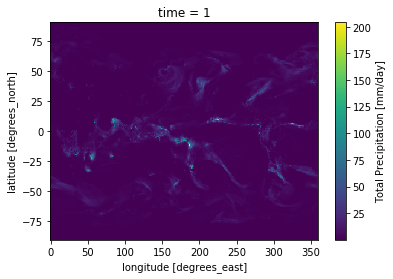

In [18]:
out_ds.TP.isel(time=1).plot()